In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline
from ipywidgets import interact, interactive, fixed

This image is: <class 'numpy.ndarray'> with dimensions: (1432, 2560, 3)


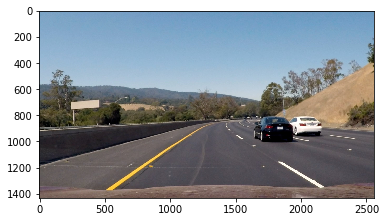

In [3]:

#reading in an image
image = mpimg.imread('videotest.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image,cmap='gray')  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def convert_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def canny(img, low_threshold, high_threshold): ## """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
      #LINE DISPLAY PARAMETERS
    color = [243, 105, 14]
    thickness = 12
    
    #LINE PARAMETERS
    SLOPE_THRESHOLD = 0.3
    Y_MIN_ADJUST = 15
    
    positive_slopes = []
    negative_slopes = []
    
    positive_intercepts = []
    negative_intercepts = []
    
    #named as y_max despte being at the bottom corner of the image due to y axis in reverse direction
    y_max = img.shape[0]
    y_min = img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #calculate slope for the line
            slope = (y2-y1)/(x2-x1)
            intercept = y2 - (slope*x2)
            
            #for negative slope
            if slope < 0.0 and slope > -math.inf and abs(slope) > SLOPE_THRESHOLD:
                #print('negative slope')
                negative_slopes.append(slope)
                negative_intercepts.append(intercept)
                
            #for positive slope
            elif slope > 0.0 and slope < math.inf and abs(slope) > SLOPE_THRESHOLD:
                #print('positive slope')
                positive_slopes.append(slope)
                positive_intercepts.append(intercept)
            
            y_min = min(y_min, y1, y2)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    y_min+=Y_MIN_ADJUST
    
    #get averages for positive and negative slopes
    positive_slope_mean = np.mean(positive_slopes)
    negative_slope_mean = np.mean(negative_slopes)

    #get averages for potitive and negative intercepts
    positive_intercept_mean = np.mean(positive_intercepts)
    negative_intercept_mean = np.mean(negative_intercepts)
    
    #calculation of coordinates for lane for positive slopes
    if len(positive_slopes) > 0:
        x_max = int((y_max - positive_intercept_mean)/positive_slope_mean)
        x_min = int((y_min - positive_intercept_mean)/positive_slope_mean)
        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    #calculation of coordinates for lane for negative slopes
    if len(negative_slopes) > 0:
        x_max = int((y_max - negative_intercept_mean)/negative_slope_mean)
        x_min = int((y_min - negative_intercept_mean)/negative_slope_mean)
        cv2.line(img, (x_min, y_min), (x_max, y_max), color, thickness)
           

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    img = np.uint8(img)
    if len(img.shape) is 2:
        img = np.dstack((img, np.zeros_like(img), np.zeros_like(img)))
    return cv2.addWeighted(initial_img, α, img, β, γ)

def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask

In [5]:
grayscale(image)

array([[171, 192, 153, ..., 145, 185, 148],
       [177, 154, 159, ..., 150, 149, 160],
       [166, 152, 160, ..., 145, 142, 159],
       ...,
       [ 97, 106, 104, ..., 102, 101,  96],
       [ 81, 104, 106, ..., 100,  98,  84],
       [ 67, 101, 106, ...,  98,  92,  69]], dtype=uint8)

In [6]:
import os
os.listdir("data/")

['frame226.jpg',
 'frame232.jpg',
 'frame193.jpg',
 'frame187.jpg',
 'frame85.jpg',
 'frame91.jpg',
 'frame150.jpg',
 'frame144.jpg',
 'frame46.jpg',
 'frame52.jpg',
 'frame178.jpg',
 'frame53.jpg',
 'frame179.jpg',
 'frame47.jpg',
 'frame145.jpg',
 'frame151.jpg',
 'frame90.jpg',
 'frame84.jpg',
 'frame186.jpg',
 'frame192.jpg',
 'frame233.jpg',
 'frame227.jpg',
 'frame231.jpg',
 'frame225.jpg',
 'frame219.jpg',
 'frame184.jpg',
 'frame190.jpg',
 'frame92.jpg',
 'frame86.jpg',
 'frame147.jpg',
 'frame79.jpg',
 'frame153.jpg',
 'frame51.jpg',
 'frame45.jpg',
 'frame44.jpg',
 'frame50.jpg',
 'frame78.jpg',
 'frame152.jpg',
 'frame146.jpg',
 'frame87.jpg',
 'frame93.jpg',
 'frame191.jpg',
 'frame185.jpg',
 'frame218.jpg',
 'frame224.jpg',
 'frame230.jpg',
 'frame208.jpg',
 'frame234.jpg',
 'frame220.jpg',
 'frame97.jpg',
 'frame83.jpg',
 'frame181.jpg',
 'frame195.jpg',
 'frame54.jpg',
 'frame40.jpg',
 'frame68.jpg',
 'frame142.jpg',
 'frame156.jpg',
 'frame157.jpg',
 'frame69.jpg',
 'fr

# Build a Lane Finding Pipeline

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#GAUSSIAN BLUR PARAMETERS
KERNEL_SIZE = 3

#CANNY EDGE DETECTION PARAMETERS
LOW_THRESHOLD = 75 
HIGH_THRESHOLD = 150 

#REGION OF INTEREST PARAMETERS
H_CONST = 0.08
RIGHT_LANE_SLOPE = 14/32
RIGHT_LANE_CONST = 400
TOP_SHIFT_H = 40 
TOP_SHIFT_V = 40

#HOUGH LINES PARAMETERS
RHO = 3.5 
THETA = np.pi/180
MIN_VOTES = 30    
MIN_LINE_LEN = 5 
MAX_LINE_GAP= 25  
LOWER_EDGE = 800


def get_region_of_interest_vertices(img):
    
    #get image parameters for extracting the region of interest
    img_height = img.shape[0]
    img_width = img.shape[1]

    bottom_left = (img_width/9 - H_CONST*img_width, img_height)
    top_left = (img_width / 2 - (TOP_SHIFT_H ), img_height / 2 + TOP_SHIFT_V)
    top_right = (img_width /2 + TOP_SHIFT_H, img_height/2 + TOP_SHIFT_V)
    bottom_right = (img_width - (RIGHT_LANE_SLOPE*img_width-RIGHT_LANE_CONST) + 
                         (H_CONST*img_width), img_height)
    
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
                        
    #print ('vertices-->', vertices)
    return vertices

def build_pipeline(img, mode = 'complete'):
    
    #gray out the image
    hsv_img = convert_to_hsv(img)
   
    #smoothen the image
    smooth_img = gaussian_blur(hsv_img, KERNEL_SIZE)
    
    # Define color ranges and apply color mask
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    
    mask_yellow = color_mask(smooth_img,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(smooth_img,white_hsv_low,white_hsv_high)
    
    mask_img = cv2.bitwise_or(mask_yellow,mask_white) 
    
    #canny edge detection
    canny_img = canny(mask_img, LOW_THRESHOLD, HIGH_THRESHOLD)
     
    #vertices for extracting desired portion from the image
    vertices = get_region_of_interest_vertices(img)
    
    #poly_img = cv2.polylines(img, vertices, True, (0,255,255),3)
   
    #get portion corresponding to the region of interest from the image
    regions = region_of_interest(canny_img, vertices)
    
    if mode == 'canny':
        return regions
    else:
        #get hough lines for the lanes found in the img
        hough_img = hough_lines(regions, RHO, THETA, MIN_VOTES, MIN_LINE_LEN, MAX_LINE_GAP)

        #return original image masked by the hough lines 
        return weighted_img(hough_img, img)

# Visualization

In [8]:
def load_images(image_type):
    if image_type == 'data':
        glob_regex = 'data/*.jpg'
    elif image_type == 'challenge':
        glob_regex = 'challenge_images/*.jpeg'
    else:
        print('Invalid Type')
        return
    images=[]
    for f in glob.glob(glob_regex):
  
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images


def visualize_transformation(images):
    n = len(images)
    
    def view_image(i):
        file, img = images[i]
        
        canny_img = build_pipeline(img, 'canny')
        
        dst_img = build_pipeline(img)
            
        # Visualize transformation
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(canny_img, cmap = 'gray')
        ax2.set_title('Canny Image', fontsize=30)
        ax3.imshow(dst_img)
        ax3.set_title('Final Image', fontsize=30)
        
    interact(view_image, i=(0,n-1))

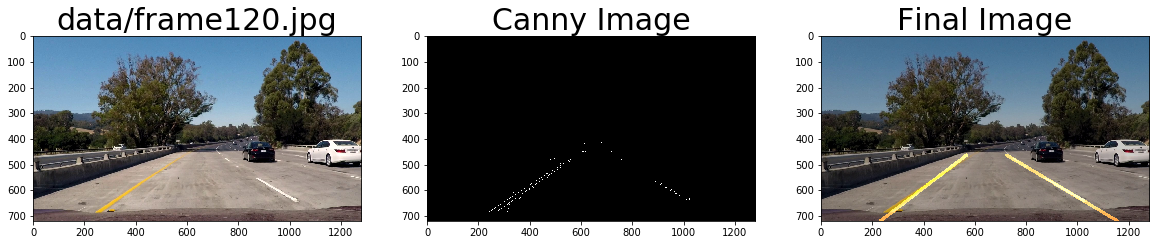

In [9]:

images = load_images('data')
visualize_transformation(images)

# Videos testing

In [29]:

# Import everything needed to edit/save/watch video clips# Impor 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = build_pipeline(image)
    return result

# Video 1


In [31]:
# Playing video from file:
cap = cv2.VideoCapture('test.mp4')

try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print ('Error: Creating directory of data')

currentFrame = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Saves image of the current frame in jpg file
    name = './data/frame' + str(currentFrame) + '.jpg'
    print ('Creating...' + name)
    cv2.imwrite(name, frame)

    # To stop duplicate images
    currentFrame += 1

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr